In [16]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

In [8]:
#load
rim_metrics = pd.read_csv("/Users/rushil/brain_extraction/results/quantitative/rim_metrics_r1.csv")

#exlude these scans:
exclude = ['6109-317_20150302_0647_ct', '6142-308_20150610_0707_ct', '6193-324_20150924_1431_ct', '6257-335_20160118_1150_ct',
                     '6418-193_20161228_1248_ct', '6470-296_20170602_0607_ct', '6480-154_20170622_0937_ct']

rim_metrics = rim_metrics[~rim_metrics["stem"].isin(exclude)]

# Split by method
synth = rim_metrics[rim_metrics["method"] == "synth"].set_index("stem")
robust = rim_metrics[rim_metrics["method"] == "robust"].set_index("stem")

# Keep only paired scans
paired = synth.join(robust, lsuffix="_synth", rsuffix="_robust")

# Number of paired scans
print("N paired:", len(paired))

# Compute medians/IQRs for each metric
summary = paired.describe(percentiles=[0.25,0.5,0.75]).T[["25%","50%","75%"]]

# Extract only key metrics
metrics_of_interest = [
    "rim_vol_ml", "frac_bone", "vol_bone_ml",
    "frac_air", "vol_air_ml", "p95", "p99"
]

summary = summary.loc[
    [m+"_synth" for m in metrics_of_interest] +
    [m+"_robust" for m in metrics_of_interest]
]

print(summary)

N paired: 5109
                            25%          50%          75%
rim_vol_ml_synth     181.156924   202.857397   217.267418
frac_bone_synth        0.515497     0.590633     0.674743
vol_bone_ml_synth     99.086523   114.440086   127.947095
frac_air_synth         0.000514     0.001456     0.003401
vol_air_ml_synth       0.096560     0.276565     0.648286
p95_synth            759.000000   879.000000  1003.000000
p99_synth           1033.000000  1157.000000  1278.000000
rim_vol_ml_robust    178.725551   200.762085   216.514395
frac_bone_robust       0.092672     0.114504     0.152091
vol_bone_ml_robust    18.345697    21.927280    27.201459
frac_air_robust        0.000000     0.000000     0.000000
vol_air_ml_robust      0.000000     0.000000     0.000000
p95_robust            81.000000    84.000000    87.000000
p99_robust            96.000000    97.000000    97.000000


In [11]:
# Compute per-scan deltas
deltas = pd.DataFrame({
    "frac_bone_delta": paired["frac_bone_synth"] - paired["frac_bone_robust"],
    "vol_bone_ml_delta": paired["vol_bone_ml_synth"] - paired["vol_bone_ml_robust"],
    "frac_air_delta": paired["frac_air_synth"] - paired["frac_air_robust"],
    "vol_air_ml_delta": paired["vol_air_ml_synth"] - paired["vol_air_ml_robust"],
    "p95_delta": paired["p95_synth"] - paired["p95_robust"],
    "p99_delta": paired["p99_synth"] - paired["p99_robust"],
})

median_deltas = deltas.median()

# Improvement rates (% of scans where Robust < Synth)
improvement_rates = (deltas > 0).mean() * 100

# Combine into one table
delta_summary = pd.DataFrame({
    "Median_Delta": median_deltas,
    "Pct_Robust_Better_across_all_scans": improvement_rates
}).round(3)

print(delta_summary)

                   Median_Delta  Pct_Robust_Better_across_all_scans
frac_bone_delta           0.471                              99.941
vol_bone_ml_delta        90.166                              99.824
frac_air_delta            0.001                              97.416
vol_air_ml_delta          0.277                              97.416
p95_delta               795.000                             100.000
p99_delta              1060.000                             100.000


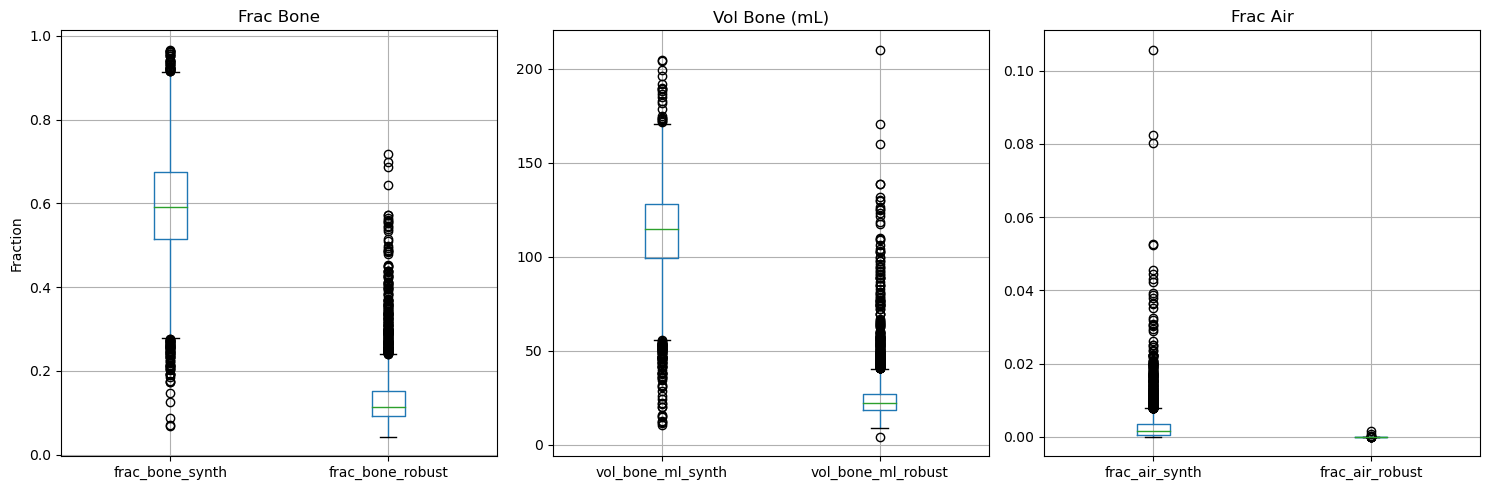

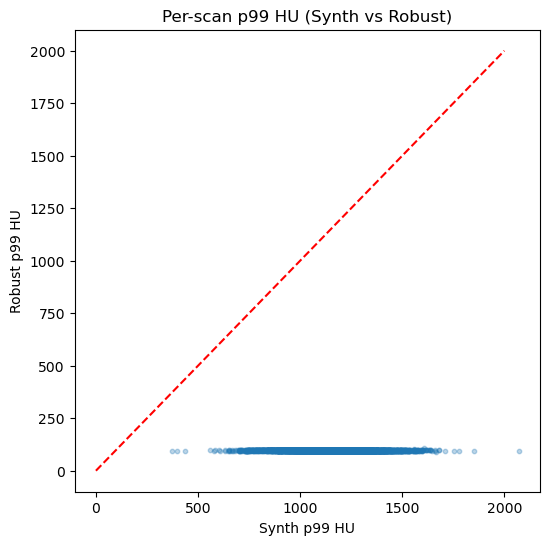

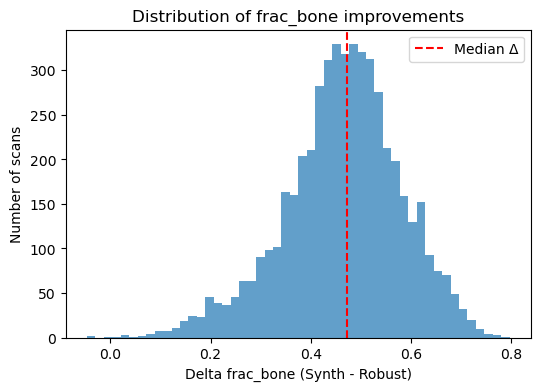

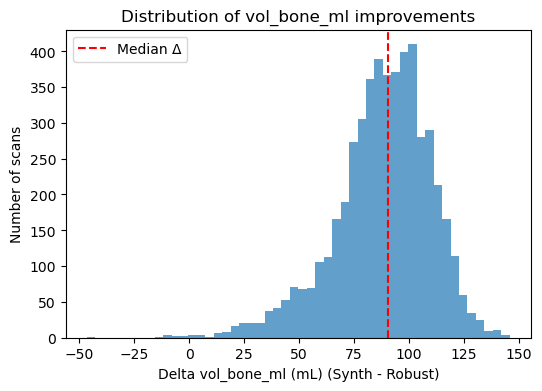

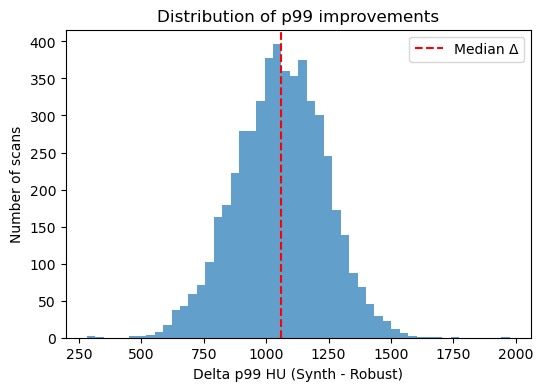

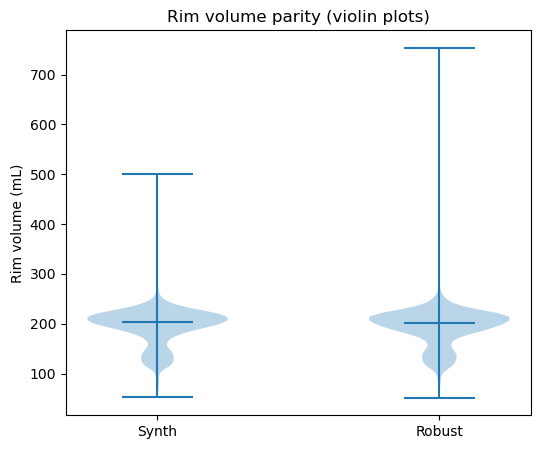

In [14]:
# --- Existing panels ---
fig, axes = plt.subplots(1, 3, figsize=(15,5))
paired[["frac_bone_synth","frac_bone_robust"]].boxplot(ax=axes[0])
axes[0].set_title("Frac Bone")
axes[0].set_ylabel("Fraction")

paired[["vol_bone_ml_synth","vol_bone_ml_robust"]].boxplot(ax=axes[1])
axes[1].set_title("Vol Bone (mL)")

paired[["frac_air_synth","frac_air_robust"]].boxplot(ax=axes[2])
axes[2].set_title("Frac Air")

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(paired["p99_synth"], paired["p99_robust"], alpha=0.3, s=10)
plt.plot([0,2000],[0,2000],'r--')
plt.xlabel("Synth p99 HU")
plt.ylabel("Robust p99 HU")
plt.title("Per-scan p99 HU (Synth vs Robust)")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(deltas["frac_bone_delta"], bins=50, alpha=0.7)
plt.axvline(deltas["frac_bone_delta"].median(), color="red", linestyle="--", label="Median Δ")
plt.xlabel("Delta frac_bone (Synth - Robust)")
plt.ylabel("Number of scans")
plt.title("Distribution of frac_bone improvements")
plt.legend()
plt.show()

# --- New panels requested ---

# Histogram of per-scan delta vol_bone_ml
plt.figure(figsize=(6,4))
plt.hist(deltas["vol_bone_ml_delta"], bins=50, alpha=0.7)
plt.axvline(deltas["vol_bone_ml_delta"].median(), color="red", linestyle="--", label="Median Δ")
plt.xlabel("Delta vol_bone_ml (mL) (Synth - Robust)")
plt.ylabel("Number of scans")
plt.title("Distribution of vol_bone_ml improvements")
plt.legend()
plt.show()

# Histogram of per-scan delta p99
plt.figure(figsize=(6,4))
plt.hist(deltas["p99_delta"], bins=50, alpha=0.7)
plt.axvline(deltas["p99_delta"].median(), color="red", linestyle="--", label="Median Δ")
plt.xlabel("Delta p99 HU (Synth - Robust)")
plt.ylabel("Number of scans")
plt.title("Distribution of p99 improvements")
plt.legend()
plt.show()

# Paired violin plots for rim_vol_ml
data_s = paired["rim_vol_ml_synth"].dropna().values
data_r = paired["rim_vol_ml_robust"].dropna().values

plt.figure(figsize=(6,5))
parts = plt.violinplot([data_s, data_r], positions=[1,2], showmedians=True)
plt.xticks([1,2], ["Synth", "Robust"])
plt.ylabel("Rim volume (mL)")
plt.title("Rim volume parity (violin plots)")
plt.show()

stat: 4017284.0 , pval: 3.2242256759482e-125


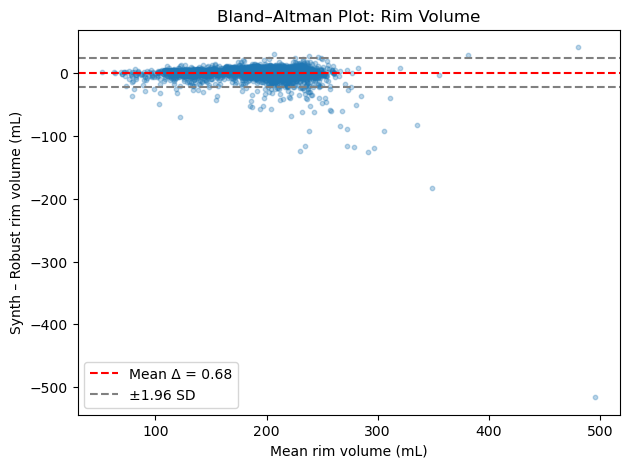

In [19]:
# Paired Wilcoxon test on rim volumes
stat, pval = wilcoxon(paired["rim_vol_ml_synth"], paired["rim_vol_ml_robust"])
print("stat:", stat, ", pval:", pval)

mean_vals = (paired["rim_vol_ml_synth"] + paired["rim_vol_ml_robust"]) / 2
diff_vals = paired["rim_vol_ml_synth"] - paired["rim_vol_ml_robust"]

mean_diff = np.mean(diff_vals)
sd_diff = np.std(diff_vals)

# Bland–Altman plot
plt.figure(figsize=(7,5))
plt.scatter(mean_vals, diff_vals, alpha=0.3, s=10)
plt.axhline(mean_diff, color='red', linestyle='--', label=f"Mean Δ = {mean_diff:.2f}")
plt.axhline(mean_diff + 1.96*sd_diff, color='grey', linestyle='--', label="±1.96 SD")
plt.axhline(mean_diff - 1.96*sd_diff, color='grey', linestyle='--')
plt.xlabel("Mean rim volume (mL)")
plt.ylabel("Synth – Robust rim volume (mL)")
plt.title("Bland–Altman Plot: Rim Volume")
plt.legend()
plt.show()


In [20]:
# Define thresholds
p99_thresh = max(paired["p99_robust"])
frac_bone_thresh = 0.75

# Flag scans based on thresholds
flags = pd.DataFrame({
    "Synth_p99_flag": paired["p99_synth"] > p99_thresh,
    "Robust_p99_flag": paired["p99_robust"] > p99_thresh,
    "Synth_frac_bone_flag": paired["frac_bone_synth"] > frac_bone_thresh,
    "Robust_frac_bone_flag": paired["frac_bone_robust"] > frac_bone_thresh
})

# Compute percentages flagged
flag_rates = flags.mean() * 100
flag_rates


Synth_p99_flag           100.000000
Robust_p99_flag            0.000000
Synth_frac_bone_flag      13.016246
Robust_frac_bone_flag      0.000000
dtype: float64